In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SAVE_PATH = '/content/drive/MyDrive/train'


In [ ]:
Str_to_Int = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma':5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis':7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9


def str_to_Int_mapper(val):
    return Str_to_Int[val]

This Load and resize images, is computationally high(16m in this case)

In [ ]:
# import os
# from PIL import Image  # Used ONLY for decoding image formats like JPG/PNG

# # Resize manually (nearest-neighbor)
# def resize_image(image, old_w, old_h, new_w=240, new_h=240):
#     resized = []
#     for i in range(new_h):
#         row = []
#         for j in range(new_w):
#             x = int(j * old_w / new_w)
#             y = int(i * old_h / new_h)
#             row.append(image[y][x])  # Nearest-neighbor pixel
#         resized.append(row)
#     return resized

# # Convert image to normalized pixel list
# def read_rgb_image(filepath):
#     try:
#         img = Image.open(filepath)
#         img = img.convert('RGB')  # Ensure it's in RGB mode
#         width, height = img.size
#         raw_pixels = list(img.getdata())  # Flat list of (r,g,b)

#         # Flat list converted to 2D normalized RGB matrix
#         rgb_image = []
#         for y in range(height):
#             row = []
#             for x in range(width):
#                 idx = y * width + x
#                 r, g, b = raw_pixels[idx]
#                 row.append([r / 255.0, g / 255.0, b / 255.0])  # Normalize
#             rgb_image.append(row)

#         return rgb_image, width, height
#     except Exception as e:
#         print(f"Error reading image {filepath}: {e}")
#         return None, None, None

# # Dataset creation
# IMG_SAVE_PATH = "/content/drive/MyDrive/train"  # Training data location

# dataset = []
# for directory in os.listdir(IMG_SAVE_PATH):
#     path = os.path.join(IMG_SAVE_PATH, directory)
#     if not os.path.isdir(path):
#         continue
#     for image in os.listdir(path):
#         new_path = os.path.join(path, image)
#         img, w, h = read_rgb_image(new_path)
#         if img is None:
#             continue
#         resized_img = resize_image(img, w, h, 240, 240)
#         dataset.append([resized_img, directory])


For Faster Load and resize we use libraries(7 seconds)

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

dataset = []
for directory in os.listdir(IMG_SAVE_PATH):
    path = os.path.join(IMG_SAVE_PATH, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath = Image.open(new_path)
            imgpath = imgpath.convert('RGB')                 # Ensure 3 channels
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240, 240))                # Resize to 240x240
            img = img / 255.0                                # Normalize
            dataset.append([img, directory])                 # Append to dataset
        except FileNotFoundError:
            print(f'File not found: {new_path}')
        except Exception as e:
            print(f"Error processing {new_path}: {e}")


In [ ]:
data = []
labels = []
for item in dataset:
    data.append(item[0])
    labels.append(item[1])

temp = []
for label in labels:
    temp.append(str_to_Int_mapper(label))


In [ ]:
def to_categorical_manual(labels):
    num_classes = max(labels) + 1
    one_hot = []
    for label in labels:
        vec = [0] * num_classes
        vec[label] = 1
        one_hot.append(vec)
    return one_hot

labels = to_categorical_manual(temp)


# DenseNet

In [ ]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pretrained DenseNet (no top)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Build custom model manually using Functional API
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Use built-in layer
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile for training
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Define your model as a list of layers with their info
model_layers = [
    {"name": "DenseNet121", "output_shape": (None, 7, 7, 1024), "params": 7037504},
    {"name": "GlobalAveragePooling2D", "output_shape": (None, 1024), "params": 0},
    {"name": "Dropout", "output_shape": (None, 1024), "params": 0},
    {"name": "Dense", "output_shape": (None, 9), "params": 9225},
]

def print_model_summary(layers):
    print("Layer (type)                Output Shape              Param #")
    print("==============================================================")
    total_params = 0
    for layer in layers:
        print(f"{layer['name']:<25} {str(layer['output_shape']):<25} {layer['params']}")
        total_params += layer['params']
    print("==============================================================")
    print(f"Total params: {total_params}")

# Usage
print_model_summary(model_layers)


Layer (type)                Output Shape              Param #
DenseNet121               (None, 7, 7, 1024)        7037504
GlobalAveragePooling2D    (None, 1024)              0
Dropout                   (None, 1024)              0
Dense                     (None, 9)                 9225
Total params: 7046729


In [ ]:
history=model.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.2)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 660s 31s/step - accuracy: 0.1296 - loss: 2.9858 - val_accuracy: 0.0429 - val_loss: 2.2591
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 571s 32s/step - accuracy: 0.4325 - loss: 1.6065 - val_accuracy: 0.0500 - val_loss: 2.3733
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 559s 31s/step - accuracy: 0.7029 - loss: 0.8921 - val_accuracy: 0.0571 - val_loss: 2.4222
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 558s 31s/step - accuracy: 0.7854 - loss: 0.6387 - val_accuracy: 0.0929 - val_loss: 2.4341
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 560s 31s/step - accuracy: 0.8988 - loss: 0.3822 - val_accuracy: 0.0929 - val_loss: 2.5194


In [ ]:
from matplotlib import pyplot as plt

def plot_acc(history_dict):
    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(range(len(history_dict['accuracy'])), history_dict['accuracy'], label='train')
    ax1.plot(range(len(history_dict['val_accuracy'])), history_dict['val_accuracy'], label='valid')
    ax1.set_title('Accuracy')
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(len(history_dict['loss'])), history_dict['loss'], label='train')
    ax2.plot(range(len(history_dict['val_loss'])), history_dict['val_loss'], label='valid')
    ax2.set_title('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()


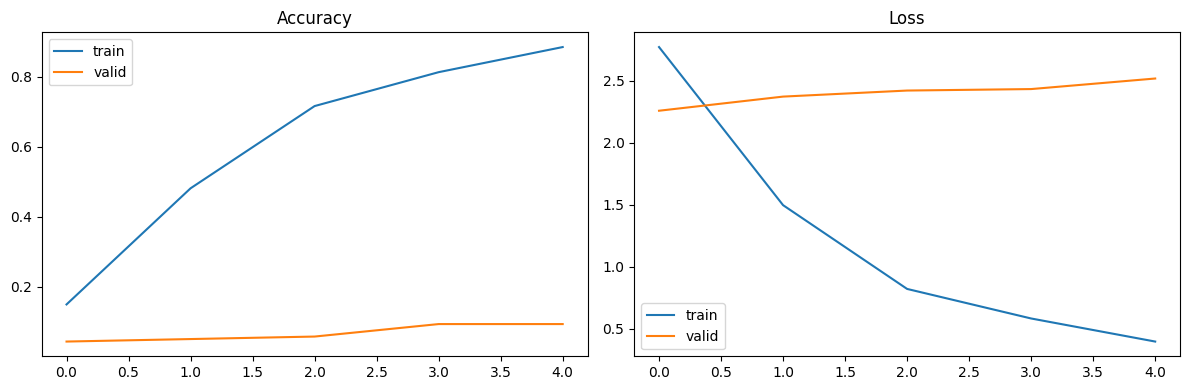

In [ ]:
plot_acc(history.history)

## Mobile Net

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dropout, Conv2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def mobilenet():
    # Load pretrained MobileNet base without top layer
    base_model = MobileNet(input_shape=(240, 240, 3), include_top=False, weights='imagenet')

    # Add custom layers manually
    x = base_model.output
    x = Dropout(0.5)(x)
    x = Conv2D(9, (1, 1), padding='valid')(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam

model_mobile = mobilenet()
model_mobile.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/tmp/ipython-input-14-2030572540.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(input_shape=(240, 240, 3), include_top=False, weights='imagenet')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# #define summary function
# def custom_summary(model):
#     print("Layer (type)                Output Shape              Param #")
#     print("==============================================================")
#     total_params = 0

#     for layer in model.layers:
#         name = layer.name
#         try:
#             output_shape = layer.output_shape
#         except AttributeError:
#             output_shape = "Not built"
#         try:
#             params = layer.count_params()
#         except:
#             params = 0
#         print(f"{name:<25} {str(output_shape):<25} {params}")
#         total_params += params

#     print("==============================================================")
#     print(f"Total params: {total_params}")
#     try:
#         trainable = sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
#         non_trainable = sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])
#         print(f"Trainable params: {trainable}")
#         print(f"Non-trainable params: {non_trainable}")
#     except:
#         print("Trainable/non-trainable params not available.")


# #use summary function
# custom_summary(model_mobile)


In [ ]:
# model_mobile.summary()

In [ ]:
history_mobile = model_mobile.fit(
    np.array(data), np.array(labels),
    epochs=5, shuffle=True, validation_split=0.3
)


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.2889 - loss: 2.0708 - val_accuracy: 0.0143 - val_loss: 3.7788
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 130s 8s/step - accuracy: 0.8107 - loss: 0.7374 - val_accuracy: 0.0381 - val_loss: 3.3678
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.9444 - loss: 0.2906 - val_accuracy: 0.0333 - val_loss: 3.1352
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step - accuracy: 0.9829 - loss: 0.1268 - val_accuracy: 0.0429 - val_loss: 3.0992
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.9948 - loss: 0.0728 - val_accuracy: 0.0952 - val_loss: 3.2124


In [ ]:
from matplotlib import pyplot as plt

def plot_acc(history_obj):
    if hasattr(history_obj, 'history'):
        history_dict = history_obj.history
    else:
        history_dict = history_obj

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Accuracy
    ax1.plot(range(len(history_dict['accuracy'])), history_dict['accuracy'], label='train')
    ax1.plot(range(len(history_dict['val_accuracy'])), history_dict['val_accuracy'], label='valid')
    ax1.set_title('Accuracy')
    ax1.legend()

    # Plot Loss
    ax2.plot(range(len(history_dict['loss'])), history_dict['loss'], label='train')
    ax2.plot(range(len(history_dict['val_loss'])), history_dict['val_loss'], label='valid')
    ax2.set_title('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

def cnn():
    model=Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(240,240,3)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))

    return model


In [ ]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

model_cnn = cnn()
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# #define summary function
# def print_model_summary(layers):
#     print("Layer (type)                Output Shape              Param #")
#     print("==============================================================")
#     total_params = 0
#     for layer in layers:
#         print(f"{layer['name']:<25} {str(layer['output_shape']):<25} {layer['params']}")
#         total_params += layer['params']
#     print("==============================================================")
#     print(f"Total params: {total_params}")

# # Example usage:
# model_layers = [
#     {"name": "Conv2D", "output_shape": (None, 238, 238, 8), "params": 224},
#     {"name": "MaxPooling2D", "output_shape": (None, 119, 119, 8), "params": 0},
#     # ... add other layers manually
# ]

# #summary function
# print_model_summary(model_layers)


In [ ]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 238, 238, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 236, 236, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 116, 116, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,561 (6.19 MB)

 Trainable params: 1,621,561 (6.19 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/5


ValueError: Creating variables on a non-first call to a function decorated with tf.function.